# MNIST training using CNN (LeNet5) 
_María Camila Vásquez Correa_

[LeNet architecture source](https://github.com/ChawDoe/LeNet5-MNIST-PyTorch)

In [0]:
from mlxtend.data import loadlocal_mnist
import torchvision.transforms as transforms
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Data loading

The dataset that is going to be used is the original [mnis dataset](http://yann.lecun.com/exdb/mnist/) that must be in the specified path (local loading)

In [0]:
X_train, y_train = loadlocal_mnist(
        images_path='/content/data/train-images-idx3-ubyte', 
        labels_path='/content/data/train-labels-idx1-ubyte')

X_test, y_test = loadlocal_mnist(
        images_path='/content/data/t10k-images-idx3-ubyte', 
        labels_path='/content/data/t10k-labels-idx1-ubyte')

### Dataset pytorch
In order to handle the data in Pytorch, we define a class MnistDataset that is an heir from the Dataset class and includes a way to know the length of the dataset as well as an indexer that retrieves the elements of the dataset in the index 'idx'.

In [0]:
class MNISTDataset(Dataset):    
    def __init__(self, X, y, size = 28, transform=None):
        self.X = X
        self.y = y
        self.size = size
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'image': self.X[idx,:].reshape(28,28), 'label': self.y[idx]}
        sample['image'] = np.array(transforms.Resize(self.size)(transforms.ToPILImage()(sample['image'])))
        sample['image'] = transforms.ToTensor()(sample['image']).reshape(1,self.size, self.size)

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

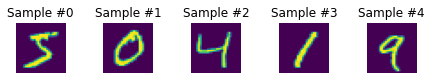

In [4]:
mnist = MNISTDataset(X_train, y_train)

fig = plt.figure()

for i in range(5):
    sample = mnist[i]

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(sample['image'].reshape(28,28))
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
plt.show()

## LeNet 5
This architecture built in Python can be found [here](https://github.com/ChawDoe/LeNet5-MNIST-PyTorch).

In [0]:
from torch.nn import Module
from torch import nn


class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

In [6]:
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader

batch_size = 256
model = Model()
train_dataset = MNISTDataset(X_train, y_train, size = 28)
test_dataset = MNISTDataset(X_test, y_test, size = 28)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
sgd = SGD(model.parameters(), lr=1e-1)
cross_error = CrossEntropyLoss()
epoch = 10

loss = []
for _epoch in range(epoch):
    errors = []
    for idx, d_point in enumerate(train_loader):
        train_label = d_point['label']
        train_x = d_point['image']
        label_np = np.zeros((train_label.shape[0], 10))
        sgd.zero_grad()
        predict_y = model(train_x.float())
        _error = cross_error(predict_y, train_label.long())
        _error.backward()
        errors.append(_error.detach().numpy())
        sgd.step()
    if _epoch % 10 == 0:
            print('idx: {}, _error: {}'.format(_epoch, np.mean(errors)))
    loss.extend(errors)

    correct = 0
    _sum = 0

    for idx, d_point in enumerate(test_loader):
        test_label = d_point['label']
        predict_y = model(d_point['image'].float()).detach()
        predict_ys = np.argmax(predict_y, axis=-1)
        label_np = test_label.numpy()
        _ = predict_ys == test_label
        correct += np.sum(_.numpy(), axis=-1)
        _sum += _.shape[0]
    if _epoch % 10 == 0:
      print('accuracy: {:.2f}'.format(correct / _sum))
      torch.save(model, 'mnist_{:.2f}.pkl'.format(correct / _sum))

idx: 0, _error: 1.8256009817123413
accuracy: 0.77


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


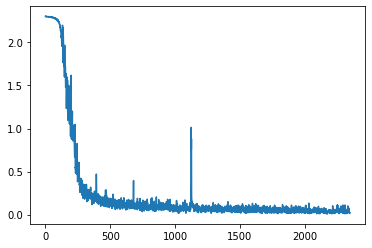

In [7]:
plt.plot(loss)
plt.show()